<a href="https://colab.research.google.com/github/SUMIN-WEE/NLP/blob/master/0723_sentence_piece_%EC%8B%A4%EC%8A%B5(%2BLSTM)(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SENTENCE PIECE(+LSTM)

<ul>
  <li> DATA_20newsgroup(subject)이용</li>
  <li>전처리_sentence piece</li>
  <li>모델_LSTM으로 주제 분류</li>
  <li>출력_ACC는?</li>
  </ul>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# /content/drive/MyDrive/Colab Notebooks/data/news_data/newsgroup20.pkl

In [4]:
# -*- coding: utf-8 -*-
"""news_group20(subject).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/19ntMHFOe4wGQISMP54jCB4TpsEqRxKrz
"""

# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import re
import pickle
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# %cd '/content/drive/MyDrive/Colab Notebooks'

# news data를 읽어온다. subject 분석용.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))

# 첫 번째 news를 조회해 본다.
news = newsData['data']
topic = newsData['target']
topic_name = newsData['target_names']
n=0
print(len(news))
print(news[n])
print('topic = ', topic[n], topic_name[topic[n]])

# Subject만 추출한다.
subjects = []
for text in news:
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:       # found
            subjects.append(sent[(idx + 9):].replace('Re: ', ''))
            break



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
11314
From: ab4z@Virginia.EDU ("Andi Beyer")
Subject: Re: Israeli Terrorism
Organization: University of Virginia
Lines: 15
topic =  17 talk.politics.mideast


In [5]:
# subject를 전처리한다.
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

# 1. 영문자가 아닌 문자를 모두 제거한다.
subject1 = [re.sub("[^a-zA-Z]", " ", s) for s in subjects]

# 2. 불용어를 제거하고, 모든 단어를 소문자로 변환하고, 길이가 2 이하인 
# 단어를 제거한다
# 3. Porterstemmer를 적용한다.
subject2 = []
for sub in subject1:
    tmp = []
    for w in sub.split():
        w = w.lower()
        if len(w) > 2 and w not in stop_words:
            tmp.append(stemmer.stem(w))
    subject2.append(' '.join(tmp))



In [6]:
# news data를 다시 읽어온다. news의 body 부분 처리.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
news = newsData['data']



In [7]:
# body 부분을 전처리한다.

# 1. 영문자가 아닌 문자를 모두 제거한다.
news1 = [re.sub("[^a-zA-Z]", " ", s) for s in subjects]

# 2. 불용어를 제거하고, 모든 단어를 소문자로 변환하고, 길이가 3 이하인 
# 단어를 제거한다
# 3. Porterstemmer를 적용한다.
news2 = []
for doc in news1:
    doc1 = []
    for w in doc.split():
        w = w.lower()
        if len(w) > 3 and w not in stop_words:
            doc1.append(stemmer.stem(w))
    news2.append(' '.join(doc1))



In [8]:
# 전처리가 완료된 데이터를 저장한다.
with open('/content/drive/MyDrive/Colab Notebooks/data/news_data/newsgroup20.pkl', 'wb') as f:
    pickle.dump([subject2, news2, topic], f, pickle.DEFAULT_PROTOCOL)

In [9]:
# -*- coding: utf-8 -*-
"""news_group20(LSTM).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1x94rt9mvcG9NZjg-gUMkxakeKho5uPpT
"""

# Commented out IPython magic to ensure Python compatibility.
# LSTM으로 subject를 clasification한다.
# ------------------------------------
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# %cd '/content/drive/MyDrive/Colab Notebooks'

# 전처리가 완료된 한글 코퍼스를 읽어온다.
with open('/content/drive/MyDrive/Colab Notebooks/data/news_data/newsgroup20.pkl', 'rb') as f:
    subject, text, topic = pickle.load(f)



In [10]:
n_topic = len(set(topic))

max_word = 5000
tokenizer = Tokenizer(num_words = max_word, oov_token = '<OOV>')
tokenizer.fit_on_texts(subject)
sent_idx = tokenizer.texts_to_sequences(subject)
word2idx = {k:v for (k, v) in list(tokenizer.word_index.items())[:max_word]}
word2idx['<PAD>'] = 0
idx2word = {v:k for (k, v) in word2idx.items()}



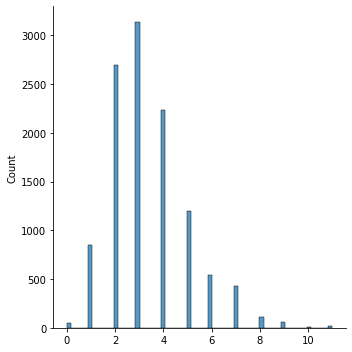

In [11]:
# subject을 길이 분포를 확인한다.
n_len = [len(sub) for sub in sent_idx]
sns.displot(n_len)
plt.show()

# 문장의 길이를 6으로 맞춘다.
x_data = pad_sequences(sent_idx, maxlen=6, padding='post', truncating='post')
y_data = topic



In [12]:
# 학습 데이터와 시험데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape



((9051, 6), (9051, 1), (2263, 6), (2263, 1))

In [13]:
# NPLM 모델을 생성한다.
EMB_SIZE = 32
VOCAB_SIZE = len(word2idx) + 1
x_input = Input(batch_shape = (None, x_train.shape[1]))
x_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
x_embed = Dropout(0.5)(x_embed)
x_lstm = LSTM(64, dropout=0.5)(x_embed)
y_output = Dense(n_topic, activation = 'softmax')(x_lstm)

model = Model(x_input, y_output)     # 학습, 예측용 모델
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01))
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 6, 32)             160064    
_________________________________________________________________
dropout (Dropout)            (None, 6, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
Total params: 186,196
Trainable params: 186,196
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 모델을 학습한다.
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 512, epochs = 30)



Epoch 1/30
18/18 [==============================] - 4s 82ms/step - loss: 2.8224 - val_loss: 2.2794
Epoch 2/30
18/18 [==============================] - 1s 56ms/step - loss: 1.9807 - val_loss: 1.4156
Epoch 3/30
18/18 [==============================] - 1s 56ms/step - loss: 1.4500 - val_loss: 1.0663
Epoch 4/30
18/18 [==============================] - 1s 49ms/step - loss: 1.1446 - val_loss: 0.8631
Epoch 5/30
18/18 [==============================] - 1s 50ms/step - loss: 0.9728 - val_loss: 0.7845
Epoch 6/30
18/18 [==============================] - 1s 57ms/step - loss: 0.8765 - val_loss: 0.7434
Epoch 7/30
18/18 [==============================] - 1s 51ms/step - loss: 0.7742 - val_loss: 0.7123
Epoch 8/30
18/18 [==============================] - 1s 45ms/step - loss: 0.7090 - val_loss: 0.7122
Epoch 9/30
18/18 [==============================] - 1s 43ms/step - loss: 0.6677 - val_loss: 0.6903
Epoch 10/30
18/18 [==============================] - 1s 38ms/step - loss: 0.6180 - val_loss: 0.6899
Epoch 11/

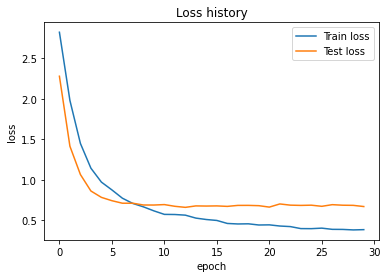


Accuracy = 84.58 %


In [15]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))



In [16]:
# 잘못 분류된 subject들을 살펴본다. 어떤 특징을 발견할 수 있을까?
mis_idx = [list(x_test[m]) for m in np.where(y_pred != y_test)[0]]

mis_sent = []
for sent in mis_idx:
    tmp = []
    for i in sent:
        if i > 0:      # pad가 아니면
            tmp.append(idx2word[i])
    mis_sent.append(tmp)
mis_sent[:10]



[['proventil', 'inhal'],
 ['prodig', 'son'],
 ['load', 'network'],
 ['copi', 'move', 'file', 'file', 'manag'],
 ['espn', 'tb', 'game'],
 ['ottomenu', 'get'],
 ['put'],
 ['faq', 'group'],
 ['summari', '<OOV>', 'string'],
 ['legal', 'definit', 'religion']]

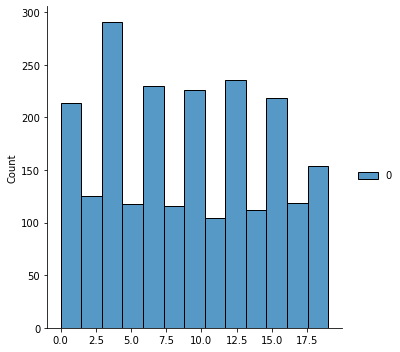

In [17]:
# 잘못 분류된 subject들을 살펴본다. 어떤 특징을 발견할 수 있을까?
good_idx = [list(x_test[m]) for m in np.where(y_pred == y_test)[0]]

good_sent = []
for sent in good_idx:
    tmp = []
    for i in sent:
        if i > 0:      # pad가 아니면
            tmp.append(idx2word[i])
    good_sent.append(tmp)
good_sent[:10]

sns.displot(y_pred)
plt.show()
